## Луцкий Павел Евгеньевич J4251
## Лабораторная работа 2

### Создание набора данных
1) Скачайте архив с наборами данных для задачи классификации или изучите API сайта OpenML.
При необходимости сформулируйте набор критериев для фильтрации наборов данных и исключите неподходящие датасеты (например, слишком долгая обработка, низкое качество данных и т.д.). Минимальное количество наборов данных - 300.
2) Реализуйте по несколько мета-признаков из каждой группы: базовые, статистический и структурные
3) Выберите один набор данных. Измените в нем порядок строк, столбцов и категорий при наличии категориальных признаков. Опишите, как изменились мета-признаки.
4) Выберите не менее трех алгоритмов обучения с учителем и меру оценки алгоритма обучения (валидацию)
5) Постройте мета-набор данных. Для каждого набора данных обучите каждый из выбранных ранее алгоритмов и определите наилучший. Если мета-набор данных получился сильно несбалансированным, попробуйте использовать другие алгоритмы или гиперпараметры алгоритмов обучения. Но не стоит настраивать гиперпараметры под каждый набор данных. В результате у вас должен получиться набор данных, где каждый пример - это датасет, его признаки это мета-признаки, а таргет - индекс лучшего алгоритма.
6) Определите в мета-наборе данных попарную корреляцию мета-признаков. Если обнаружите пары с высокой корреляцией, объясните причины такого поведения и исключите лишние признаки в дальнейших шагах.
Визуализируйте мета-набор данных проекцией на двумерном графике. Используйте разные цвета для разных мета-классов.  
  

### Сравнение поведения алгоритмов
7) Протестируйте несколько алгоритмов обучения с учителем (включая наивный алгоритм) на полученном наборе данных. Алгоритмы обучения могут отличаться от используемых на 5-м шаге алгоритмов. Также можно использовать другие гиперпараметры для них.
8) Для одного выбранного алгоритма проведите обучение для случаев с полным набором мета-признаков, а также для случаев в отсутствием признаков каждой из групп по отдельности (базовые, статистические, структурные). Сравните полученные метрики и объясните, подкрепив рассуждения графиками, полученные результаты.
9) Выбрав один набор данных из мета-набора и любой из обученных ранее алгоритмов, добавьте в данные шум, измените метки целевого класса и категориальные признаки. Пересчитав метапризнаки, получите новое предсказание от алгоритма. Объясните изменение метапризнаков и новое предсказание.

Импортируем необходимые библиотеки (будем использовать api openml)

In [25]:
import openml 
import pandas as pd
import numpy as np  
from typing import Dict, Any, List
import os, warnings, time
from pathlib import Path

import matplotlib.pyplot as plt 
import mplcyberpunk
plt.style.use("cyberpunk")

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

Код ниже собирает 350 датасетов и сохраняет их названия, id, количество признаков, количество сэмплов в отдельный csv файл

Также для быстрого и корректного сбора были выбраны следующие параметры 
`Минимальное число датасетов` = `300`

`Минимальное число сэмплов` = `1000`

`Максимальное число сэмплов` = `50000`

`Минимальное число признаков` = `5`

`Максимальное число признаков` = `50`

`Максимальное число классов в таргете` = `20`

`Не более 20% пропусков в датасете`

Также, характеристики датасета будем получать через встроенный в функцию `get_dataset` параметр `download_qualities`.

In [ ]:
MIN_DATASETS = 300
MIN_ROWS = 1000 
MAX_ROWS = 50000
MIN_COLS = 5
MAX_COLS = 50
MAX_CLASSES = 20
MAX_MISSING_RATE = 0.2
NUMBER_FOR_SEARCH = 4000 # брал меньше, находит только 200 датасетов

def selection():
    tasks = openml.tasks.list_tasks(output_format='dataframe')
    clf = tasks[tasks['task_type'] == 'Supervised Classification'][['tid','did','target_feature']].dropna()
    clf = clf.drop_duplicates('did').head(NUMBER_FOR_SEARCH)
    dids = clf['did'].astype(int).tolist()

    rows = []
    for did in dids:
        try:
            dset = openml.datasets.get_dataset(did, download_qualities=True)
            q = dset.qualities or {}
            n = int(q.get('NumberOfInstances', 0) or 0)
            m = int(q.get('NumberOfFeatures', 0) or 0)
            k = int(q.get('NumberOfClasses', 0) or 0)
            miss_pct = q.get('PercentageOfMissingValues', None)
            if not (MIN_ROWS <= n <= MAX_ROWS): 
                continue
            if not (MIN_COLS <= m <= MAX_COLS):
                continue
            if k < 2 or k > MAX_CLASSES:
                continue
            if miss_pct is not None:
                if (float(miss_pct)/100.0) > MAX_MISSING_RATE:
                    continue
                miss_ratio = float(miss_pct)/100.0
            else:
                miss_ratio = None
            rows.append(dict(did=did, name=dset.name, n_instances=n, n_features=m, n_classes=k, missing_ratio=miss_ratio))
        except Exception:
            continue
    return pd.DataFrame(rows)

def main():
    df = selection()
    if len(df) < MIN_DATASETS:
        print(f"Warning: only {len(df)} datasets matched; consider relaxing constraints.")
    df = df.head(350)
    df.to_csv('../datasets/selected_datasets.csv', index=False, encoding='utf-8')
    print("Saved selected_datasets.csv with", len(df), "rows")

if __name__ == "__main__":
    main()

c:\Users\Pavel\Desktop\ALLINEED\ITMO\3-rd semester\AutoML\Laba_2\automl_lab_2\.venv\Lib\site-packages\openml\tasks\functions.py:235: RuntimeWarning: Invalid xml for task 362155: 0
From {'oml:task_id': '362155', 'oml:task_type_id': '1', 'oml:task_type': 'Supervised Classification', 'oml:did': '31', 'oml:name': 'credit-g', 'oml:status': 'active', 'oml:format': 'ARFF', 'oml:input': [{'@name': 'estimation_procedure', '#text': '0'}, {'@name': 'source_data', '#text': '31'}, {'@name': 'target_feature', '#text': 'classification problem'}], 'oml:quality': [{'@name': 'MajorityClassSize', '#text': '700.0'}, {'@name': 'MaxNominalAttDistinctValues', '#text': '10.0'}, {'@name': 'MinorityClassSize', '#text': '300.0'}, {'@name': 'NumberOfClasses', '#text': '2.0'}, {'@name': 'NumberOfFeatures', '#text': '21.0'}, {'@name': 'NumberOfInstances', '#text': '1000.0'}, {'@name': 'NumberOfInstancesWithMissingValues', '#text': '0.0'}, {'@name': 'NumberOfMissingValues', '#text': '0.0'}, {'@name': 'NumberOfNumeri

Saved selected_datasets.csv with 350 rows


На работу кода ушло примерно 14 мин, в результате было записано 350 датасетов

Реализуем по несколько мета-признаков из каждой группы: базовые, статистический и структурные

Базовые:
- кол-во сэмплов
- кол-во признаков
- количество классов
- кол-во категориальных столбцов
- кол-во численных столбцов
- отношение числа сэмплов к числу признаков датасета

Пропуски:
- доля пропусков в столбце
- средняя доля пропусков по всем столбцам
- максимальная доля пропусков среди всех столбцов
- минимальная доля пропусков по столбцам
- доля столбцов, в которых вообще есть хотя бы один пропуск

Статистические:
- среднее арифметическое по всем числовым признакам от их индивидуальных средних значений
- среднее по всем числовым признакам от их дисперсий
- среднее по всем числовым признакам от их коэффициентов асимметрии
- среднее по всем числовым признакам от их эксцессов

Энтропия классов:
- энтропия распределения классов в битах
- доля наблюдений самого частого класса

Структурные:
- средняя кардинальность категориальных признаков
- отношение числа числовых признаков к числу категориальных признаков
- доля уникальных строк во всём датасете


In [2]:
def metafeatures(X, y):
    n_samples, n_features = X.shape
    y = pd.Series(y)
    n_classes = int(y.dropna().nunique())

    cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    basic = {
        'n_samples': n_samples,
        'n_features': n_features,
        'n_classes': n_classes,
        'n_categorical': cat_cols,
        'n_numeric': num_cols,
        'ratio_samples_per_feature': float(n_samples / max(1, n_features))
    }

    # пропуски
    miss_col = X.isna().mean()
    miss_overall = float(miss_col.mean())
    miss_col_max = float(miss_col.max())
    miss_col_min = float(miss_col.min())
    frac_cols_with_na = float((miss_col > 0).mean())

    # статистические (по числовым)
    stats = dict(num_mean_of_means=np.nan, num_mean_of_vars=np.nan,
                 num_mean_skew=np.nan, num_mean_kurt=np.nan)
    if len(num_cols) > 0:
        num = X[num_cols]
        stats.update(
            num_mean_of_means=float(num.mean().mean()),
            num_mean_of_vars=float(num.var(ddof=1).mean()),
            num_mean_skew=float(num.skew().mean()),
            num_mean_kurt=float(num.kurtosis().mean()),
        )

    # энтропия классов
    p = y.value_counts(normalize=True)
    class_entropy = float(-(p * np.log2(p)).sum())
    majority_class_ratio = float(p.max())

    # структурные
    avg_cat_card = float(np.mean([X[c].nunique(dropna=True) for c in cat_cols])) if cat_cols else 0.0
    ratio_num_cat = float(len(num_cols) / len(cat_cols)) if len(cat_cols) else float('inf')
    unique_rows_ratio = float(len(X.drop_duplicates()) / len(X))

    return dict(
        **basic,
        missing_ratio_overall=miss_overall,
        missing_col_max=miss_col_max,
        missing_col_min=miss_col_min,
        frac_cols_with_na=frac_cols_with_na,
        **stats,
        class_entropy=class_entropy,
        majority_class_ratio=majority_class_ratio,
        avg_cat_cardinality=avg_cat_card,
        ratio_num_cat=ratio_num_cat,
        unique_rows_ratio=unique_rows_ratio
    )

Выберем, в качестве примера один датасет из списка (второй) и получим для него мета - признаки

In [47]:
sel = pd.read_csv('./datasets/selected_datasets.csv')

# выберем один датасет (второй)
row = sel.iloc[1]
did = int(row['did'])

# загрузим метаданные и данные
dset = openml.datasets.get_dataset(did)
target = getattr(dset, "default_target_attribute", None)
X, y, categorical_indicator, attribute_names = dset.get_data(
    dataset_format='dataframe',
    target=target
)

print(dset.name, X.shape, y.nunique(dropna=True))

orig = metafeatures(X, y)
orig

mfeat-morphological (2000, 6) 10


{'n_samples': 2000,
 'n_features': 6,
 'n_classes': 10,
 'n_categorical': [],
 'n_numeric': ['att1', 'att2', 'att3', 'att4', 'att5', 'att6'],
 'ratio_samples_per_feature': 333.3333333333333,
 'missing_ratio_overall': 0.0,
 'missing_col_max': 0.0,
 'missing_col_min': 0.0,
 'frac_cols_with_na': 0.0,
 'num_mean_of_means': 1052.6997316402774,
 'num_mean_of_vars': 2353407.4348732415,
 'num_mean_skew': 0.5315671843447335,
 'num_mean_kurt': -0.5362369226243187,
 'class_entropy': 3.321928094887362,
 'majority_class_ratio': 0.1,
 'avg_cat_cardinality': 0.0,
 'ratio_num_cat': inf,
 'unique_rows_ratio': 0.944}

Теперь изменим в этом наборе данных  порядок строк, столбцов и категорий при наличии категориальных признаков. Опишем, как изменились мета-признаки.

In [ ]:
# перестановка строк
X1 = X.sample(frac=1.0, random_state=7).reset_index(drop=True)
y1 = y.loc[X1.index].reset_index(drop=True)

# перестановка столбцов
cols = X1.columns.tolist()
np.random.default_rng(7).shuffle(cols)
X2 = X1[cols]

# перестановка категорий (переименование меток без изменения частот)
X3 = X2.copy()
for c in X3.select_dtypes(include=['object','category','bool']).columns:
    vals = X3[c].dropna().unique().tolist()
    rng = np.random.default_rng(13)
    rng.shuffle(vals)
    mapping = {old: f"{c}_{i}" for i, old in enumerate(vals)}
    X3[c] = X3[c].map(mapping)

new = metafeatures(X3, y1)

In [16]:
def normalize(v):
    if isinstance(v, list):
        try:
            return sorted(v)
        except Exception:
            return v
    if isinstance(v, dict):
        try:
            return dict(sorted(v.items(), key=lambda kv: kv[0]))
        except Exception:
            return v
    return v

def compare(a: dict, b: dict):
    keys = sorted(set(a.keys()) | set(b.keys()))
    rows = []
    for k in keys:
        av = a.get(k, None)
        bv = b.get(k, None)
        avn = normalize(av)
        bvn = normalize(bv)
        changed = not pd.api.types.is_list_like(avn) and not pd.api.types.is_list_like(bvn) and (avn != bvn)
        if isinstance(avn, (list, dict)) or isinstance(bvn, (list, dict)):
            changed = repr(avn) != repr(bvn)
        rows.append({
            'feature': k,
            'original': avn if not isinstance(avn, dict) else repr(avn),
            'after': bvn if not isinstance(bvn, dict) else repr(bvn),
            'changed': changed
        })
    df = pd.DataFrame(rows)
    df = df.sort_values(['changed', 'feature'], ascending=[False, True])
    return df

df_diff = compare(orig, new)
print(df_diff.to_string(index=False))

                  feature                             original                                after  changed
            num_mean_kurt                            -0.536237                            -0.536237     True
            num_mean_skew                             0.531567                             0.531567     True
      avg_cat_cardinality                                  0.0                                  0.0    False
            class_entropy                             3.321928                             3.321928    False
        frac_cols_with_na                                  0.0                                  0.0    False
     majority_class_ratio                                  0.1                                  0.1    False
          missing_col_max                                  0.0                                  0.0    False
          missing_col_min                                  0.0                                  0.0    False
    missing_ratio_o

`changed=True` напротив `num_mean_kurt` и `num_mean_skew` — это ложноположительные срабатывания сравнения: сами значения идентичны, значит эти признаки не изменялись (типы float).

- Базовые: `n_samples`, `n_features`, `n_classes` не зависят от порядка строк или столбцов, поэтому они неизменны.​

- Пропуски: `missing_ratio_overall` — среднее по всей матрице, инвариантно к перестановке; доли по столбцам не меняются, если не изменять сами значения.​

- Статистические: `num_mean_of_means`, `num_mean_of_vars`, `skew`, `kurt` зависят от многосетового распределения значений каждого числового признака и не зависят от порядка строк/столбцов; потому они совпадают.​

- Классовая энтропия: зависит от долей классов в `y`, а перестановка строк не меняет частоты классов.​

- Структурные: `avg_cat_cardinality` и `ratio_num_cat` отражают состав типов и кардинальности категорий, которые не меняются при простой перестановке.

Выберем не менее трех алгоритмов обучения с учителем и меру оценки алгоритма обучения (валидацию)

В нашем случае это будут `logreg`, `linsvc`, `knn5`, `logreg_bal` (я убрал отсюда RandomForestClassifier, так как из-за него возникали неполадки и всё крашилось...). Метрики валидации: `acc_mean`, `bac_mean`, `f1_macro_mean`

In [3]:
def make_preprocessor(X):
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]
    num = Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler(with_mean=True))])
    cat = Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
    return ColumnTransformer([('num', num, num_cols), ('cat', cat, cat_cols)], remainder='drop')

def evaluate_all(X, y, random_state=0, pick_metric='bac'):
    pre = make_preprocessor(X)
    models = {
        'logreg': LogisticRegression(max_iter=2000, solver='lbfgs'),
        'linsvc': LinearSVC(dual=False if X.shape[0] >= X.shape[1] else True, max_iter=3000),
        # 'rf': RandomForestClassifier(n_estimators=200, random_state=random_state),
        'knn5': KNeighborsClassifier(n_neighbors=5),
        'logreg_bal': LogisticRegression(max_iter=2000, solver='lbfgs', class_weight='balanced'),
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    scoring = {'acc': 'accuracy', 'bac': 'balanced_accuracy', 'f1m': 'f1_macro'}
    rows = []
    for name, clf in models.items():
        pipe = Pipeline([('pre', pre), ('clf', clf)])
        res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score=np.nan)
        rows.append({
            'model': name,
            'acc_mean': float(np.nanmean(res['test_acc'])),
            'bac_mean': float(np.nanmean(res['test_bac'])),
            'f1_macro_mean': float(np.nanmean(res['test_f1m'])),
        })
    scores = pd.DataFrame(rows).set_index('model')
    best = scores[f'{pick_metric}_mean'].idxmax()
    return scores.reset_index(), best

Самая интересная часть: Построем мета-набор данных. Для каждого набора данных обучим каждый из выбранных ранее алгоритмов и определим наилучший. Если мета-набор данных получился сильно несбалансированным, попробуем использовать другие алгоритмы или гиперпараметры алгоритмов обучения. Но не стоит настраивать гиперпараметры под каждый набор данных. В результате у нас должен получиться набор данных, где каждый пример - это датасет, его признаки это мета-признаки, а таргет - индекс лучшего алгоритма.

In [ ]:
warnings.filterwarnings("ignore")

sel = pd.read_csv('./datasets/selected_datasets.csv')
rows, skips = [], []

for did in sel['did'].astype(int).tolist():
    t0 = time.time()
    try:
        ds = openml.datasets.get_dataset(did)
        target = ds.default_target_attribute
        if not target:
            skips.append((did, 'no_target'))
            continue
        X, y, _, _ = ds.get_data(dataset_format='dataframe', target=target)
        nunique = X.nunique(dropna=True)
        const_cols = nunique[nunique <= 1].index.tolist()
        if const_cols:
            X = X.drop(columns=const_cols)
        if pd.Series(y).dropna().nunique() < 2:
            skips.append((did, 'target_<2_classes'))
            continue

        mf = metafeatures(X, y)
        scores, best = evaluate_all(X, y, random_state=0, pick_metric='bac')
        row = dict(
            did=did,
            name=ds.name,          # имя датасета
            target=target,         # целевая колонка
            best_algo=best,        # лучший алгоритм
            elapsed_sec=round(time.time() - t0, 3),  # длительность
            **mf
        )
        for _, r in scores.iterrows():
            row[f"{r['model']}_bac"] = float(r['bac_mean'])
            row[f"{r['model']}_f1m"] = float(r['f1_macro_mean'])
            row[f"{r['model']}_acc"] = float(r['acc_mean'])
        rows.append(row)
    except Exception as e:
        skips.append((did, f'exception:{type(e).__name__}:{e}'))
        continue

meta_df = pd.DataFrame(rows)
meta_df.to_csv('./datasets/meta_dataset.csv', index=False)
pd.DataFrame(skips, columns=['did','reason']).to_csv('./datasets/additional/meta_skips.csv', index=False)
print("ok:", meta_df.shape, "skipped:", len(skips))

ok: (263, 36) skipped: 87


Пока делал, понял, что немного ошибся с таргетом, исправлю это далее, а пока сохраним датасет и посмотрим на результаты. 87 наборов пропущено, в логах написано, что недостаточно памяти для обработки, ну да ладно, работаем с тем, что осталось.

Далее определим в мета-наборе данных попарную корреляцию мета-признаков. Если обнаружим пары с высокой корреляцией, исключим лишние признаки в дальнейших шагах.

In [ ]:
meta_df = pd.read_csv('./datasets/meta_dataset.csv')

out_dir = Path('./datasets/additional')
out_dir.mkdir(parents=True, exist_ok=True)

# сервисные поля и таргет
service_cols = [c for c in ['did','name','target'] if c in meta_df.columns]
target_col = 'best_algo' if 'best_algo' in meta_df.columns else None

# числовые мета-признаки
drop_cols = ['did', 'name', 'target', 'best_algo']
num_df = meta_df.drop(columns=[c for c in drop_cols if c in meta_df.columns], errors='ignore')
num_df = num_df.select_dtypes(include=[np.number]).copy()

# иммутация медианой
num_df = num_df.fillna(num_df.median(numeric_only=True))

th = 0.9
corr = num_df.corr().abs()
cols = corr.columns

high_pairs = []
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        r = corr.iloc[i, j]
        if np.isfinite(r) and r >= th:
            high_pairs.append((cols[i], cols[j], float(r)))

pairs_df = pd.DataFrame(high_pairs, columns=['feature_1','feature_2','corr']).sort_values('corr', ascending=False)
pairs_df.to_csv(out_dir / 'correlated_pairs_0_9.csv', index=False)
print('------' * 20)
print("Пары с высокой корреляцией (|r| >= 0.9):", len(pairs_df))
print('------' * 20)
print(pairs_df.head(10))


protect = set(['n_samples','n_features','n_classes','n_numeric','n_categorical',
               'missing_ratio_overall','class_entropy','majority_class_ratio'])
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
raw_to_drop = [col for col in upper.columns if any(upper[col] >= th)]
to_drop = [c for c in raw_to_drop if c not in protect]

pd.Series(to_drop, name='dropped_features').to_csv(out_dir / 'dropped_meta_features.csv', index=False)

# отобранные мета-признаки
kept_meta_features = [c for c in num_df.columns if c not in to_drop]

# сохранить список выбранных признаков
pd.Series(kept_meta_features, name='kept_features').to_csv(out_dir / 'meta_features.csv', index=False)

# собрать и сохранить новый датасет:
cols_to_keep = service_cols[0:2] + kept_meta_features + ([target_col] if target_col else [])
clean_meta_df = meta_df[cols_to_keep].copy()

clean_meta_df.to_csv('./datasets/meta_dataset_selected.csv', index=False)
print('------' * 20)
print(f"Saved: ./datasets/meta_dataset_selected.csv with {clean_meta_df.shape[0]} rows and {clean_meta_df.shape[1]} columns")
print('------' * 20)
print(f"Dropped due to high correlation (|r|>={th}): {len(to_drop)} columns")

------------------------------------------------------------------------------------------------------------------------
Пары с высокой корреляцией (|r| >= 0.9): 28
------------------------------------------------------------------------------------------------------------------------
            feature_1         feature_2      corr
1   num_mean_of_means  num_mean_of_vars  0.998286
13         logreg_acc        linsvc_acc  0.997630
24           knn5_bac          knn5_f1m  0.995792
17         linsvc_bac        linsvc_f1m  0.993678
3          logreg_bac        logreg_f1m  0.993276
4          logreg_bac        linsvc_bac  0.986828
9          logreg_f1m        linsvc_f1m  0.986604
26     logreg_bal_bac    logreg_bal_acc  0.985433
5          logreg_bac        linsvc_f1m  0.984867
7          logreg_bac    logreg_bal_f1m  0.981654
------------------------------------------------------------------------------------------------------------------------
Saved: ../datasets/meta_dataset_selected.cs

Почти все пары — это либо разные «проекции» одной и той же метрики, либо взаимозаменяемые агрегаты одной природы, поэтому они изменяются синхронно на всех датасетах и дают очень высокую корреляцию.

- `num_mean_of_means` vs `num_mean_of_vars` `(r≈0.998)`: оба — агрегаты масштаба/разброса числовых признаков на уровне датасета; если у разных датасетов «в среднем» крупные значения признаков, у них же часто и большие дисперсии, что делает эти скаляры почти линейно связанными. Поэтому пара — типичный кандидат на удаление одного из двух.
- `logreg_acc` vs `linsvc_acc` `(r≈0.998)`, `logreg_bac` vs `linsvc_bac/f1m`, `logreg_f1m` vs `linsvc_f1m` `(r≈0.99)`: логистическая регрессия и линейный SVM — родственные линейные модели; на мета‑задаче их относительный рейтинг по датасетам почти одинаков, поэтому профили метрик по датасетам «двигаются вместе». Отсюда очень высокая межмодельная корреляция метрик.
- `knn5_bac` vs `knn5_f1m` `(r≈0.996)`, `linsvc_bac` vs `linsvc_f1m` `(r≈0.994)`, `logreg_bac vs logreg_f1m` `(r≈0.993)`: это две разные метрики для одной и той же модели; при фиксированном классовом дисбалансе и близких решающих границах ранжирование датасетов по bac и macro‑F1 почти совпадает, поэтому корреляция близка к 1.
- `logreg_bal_bac` vs `logreg_bal_acc` `(r≈0.985)`: обе метрики для одной модели; при умеренном дисбалансе acc и balanced accuracy часто монотонно связаны, особенно когда доли классов не экстремальны.
- `logreg_bac` vs `linsvc_bac/f1m` `(r≈0.987/0.985)`: тот же эффект «родственности» линейных моделей плюс высокая согласованность bac и macro‑F1 на этих задачах.

Визуализируем мета-набор данных проекцией на двумерном графике. Используем разные цвета для разных мета-классов.

Визуадизация


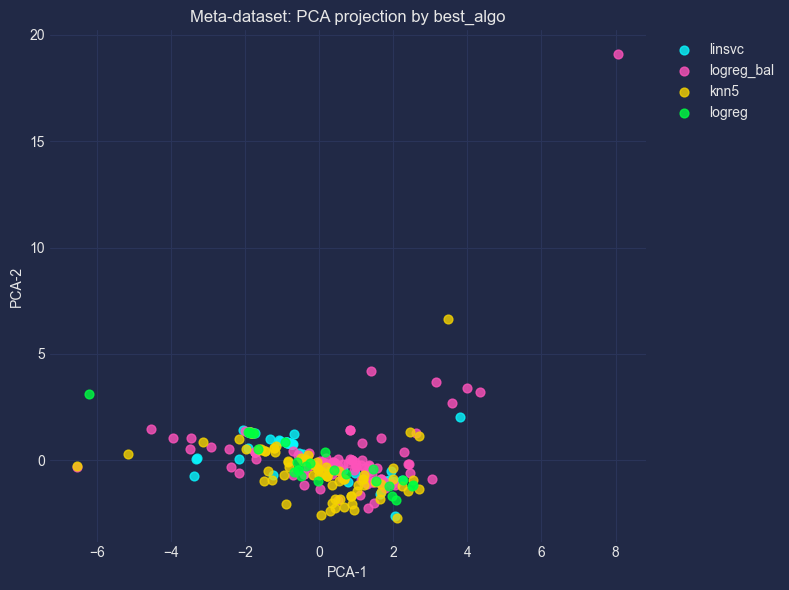

In [ ]:
meta = pd.read_csv('./datasets/meta_dataset_selected.csv')

y = meta['best_algo'] if 'best_algo' in meta.columns else None
X = meta.drop(columns=[c for c in ['did','name','best_algo'] if c in meta.columns], errors='ignore')
X = X.select_dtypes(include=[np.number]).copy()
X = X.replace([np.inf, -np.inf], np.nan)

X_scaled = StandardScaler().fit_transform(X.fillna(X.median(numeric_only=True)))

pca = PCA(n_components=2, random_state=0)
Z_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
for cls in pd.Series(y).unique():
    mask = (y == cls)
    plt.scatter(Z_pca[mask,0], Z_pca[mask,1], s=40, alpha=0.8, label=str(cls))
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('Meta-dataset: PCA projection by best_algo')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


Протестируйте несколько алгоритмов обучения с учителем (включая наивный алгоритм) на полученном наборе данных. Алгоритмы обучения могут отличаться от используемых на 5-м шаге алгоритмов. Также можно использовать другие гиперпараметры для них.

In [ ]:
meta = pd.read_csv('./datasets/meta_dataset_selected.csv')

y = meta['best_algo']
X = meta.drop(columns=[c for c in ['did', 'name', 'best_algo', 'elapsed_sec'] if c in meta.columns], errors='ignore')
X = X.select_dtypes(include=[np.number]).copy()
X = (
    X.apply(pd.to_numeric, errors='coerce')     
          .replace([np.inf, -np.inf], np.nan)         
)

pre = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('sc', StandardScaler(with_mean=True))
])

scoring = {
    'acc': 'accuracy',
    'bac': 'balanced_accuracy',
    'f1m': 'f1_macro'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

def eval_model(name, estimator):
    pipe = Pipeline([('pre', pre), ('clf', estimator)])
    res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score=np.nan, return_estimator=False)
    return {
        'model': name,
        'acc_mean': float(np.nanmean(res['test_acc'])),
        'bac_mean': float(np.nanmean(res['test_bac'])),
        'f1_macro_mean': float(np.nanmean(res['test_f1m'])),
    }

models = {
    'dummy_mf': DummyClassifier(strategy='most_frequent'),
    'logreg': LogisticRegression(max_iter=3000, solver='lbfgs'),
    'linsvc': LinearSVC(dual=False if X.shape[0] >= X.shape[1] else True, max_iter=4000),
    'rf': RandomForestClassifier(n_estimators=300, random_state=0),
    'knn5': KNeighborsClassifier(n_neighbors=5),
    'logreg_bal': LogisticRegression(max_iter=3000, solver='lbfgs', class_weight='balanced'),
}

results = []
for name, est in models.items():
    try:
        results.append(eval_model(name, est))
    except Exception as e:
        results.append({'model': name, 'acc_mean': np.nan, 'bac_mean': np.nan,
                        'f1_macro_mean': np.nan})
        print(f"[WARN] {name} failed: {type(e).__name__}: {e}")

res_df = pd.DataFrame(results).sort_values(
    ['bac_mean','f1_macro_mean'], ascending=False
)
print(res_df.to_string(index=False))

out_path = './datasets/additional/meta_model_bench.csv'
Path('./datasets/additional').mkdir(parents=True, exist_ok=True)
res_df.to_csv(out_path, index=False)
print(f"Saved: {out_path}")

     model  acc_mean  bac_mean  f1_macro_mean
    linsvc  0.745573  0.653517       0.652824
    logreg  0.715094  0.623575       0.621493
logreg_bal  0.665675  0.615313       0.606247
        rf  0.703411  0.612713       0.611491
      knn5  0.601016  0.523102       0.519732
  dummy_mf  0.372642  0.250000       0.135722
Saved: ../datasets/additional/meta_model_bench.csv


- Лидеры — линейные модели: `linsvc` на первом месте по всем метрикам, затем `logreg`; это логично, потому что мета‑признаки уже агрегированы и масштабированы, а линейные решающие границы на таких признаках работают стабильно и обобщают лучше. Разрыв по balanced accuracy от `linsvc` до `rf ≈ 0.05` — заметный.

- `class_weight='balanced'` у логистической регрессии дал прирост по bac относительно базовой acc, но уступает обычной logreg по всем метрикам — вероятно, дисбаланс таргета умеренный, и регуляризация/оценка весов без балансировки оказалась более подходящей.

- `RandomForest` держится середины таблицы: на сжатых агрегатных фичах его нелинейность даёт меньший выигрыш

- `KNN` ожидаемо проигрывает: в пространстве мета‑признаков евклидова близость не всегда отражает «сходство» по лучшему алгоритму + чувствительность к шуму даже после стандартизации.

- Наивный `baseline` существенно ниже всех — это подтверждает, что мета‑признаки несут полезный сигнал и мета‑классификатор действительно учится.

Для одного выбранного алгоритма проведите обучение для случаев с полным набором мета-признаков, а также для случаев в отсутствием признаков каждой из групп по отдельности (базовые, статистические, структурные). Сравните полученные метрики и объясните, подкрепив рассуждения графиками, полученные результаты.

Basic: 4 Stat: 2 Struct: 8 Other: 3
            acc     bac     f1m
Full     0.7417  0.6509  0.6475
-Basic   0.7721  0.6783  0.6741
-Stat    0.7532  0.6619  0.6606
-Struct  0.7341  0.6133  0.5695
Saved: ../datasets/additional/delete_meta_linsvc.png


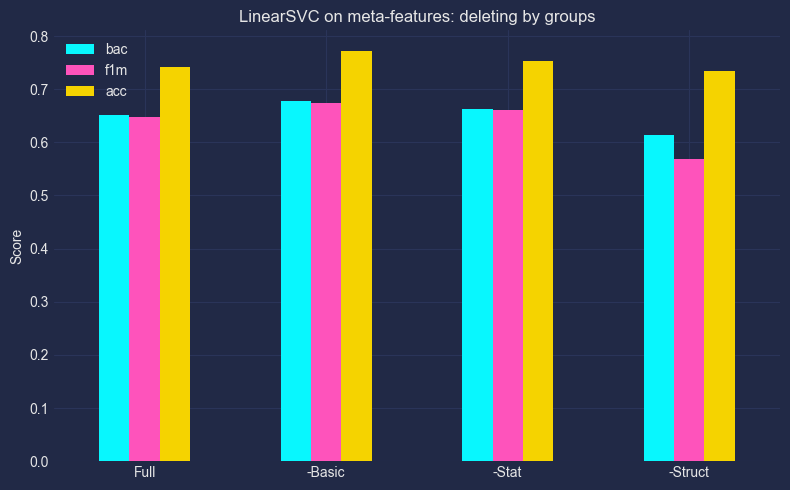

In [ ]:
X_full = meta.drop(columns=[c for c in ['did','name','best_algo', 'elapsed_sec'] if c in meta.columns], errors='ignore')
X_full = X_full.select_dtypes(include=[np.number]).copy()

X_full = X_full.replace([np.inf,-np.inf], np.nan)
X_full = X_full.fillna(X_full.median(numeric_only=True))

basic_cols = [c for c in X_full.columns if c in [
    'n_samples','n_features','n_classes','n_numeric','n_categorical',
    'ratio_samples_per_feature'
]]

stat_cols = [c for c in X_full.columns if c in [
    'num_mean_of_means','num_mean_of_vars','num_mean_skew','num_mean_kurt'
]]

struct_cols = [c for c in X_full.columns if c in [
    'missing_ratio_overall','missing_col_max','missing_col_min','frac_cols_with_na',
    'class_entropy','majority_class_ratio','avg_cat_cardinality','ratio_num_cat','unique_rows_ratio'
]]

other_cols = [c for c in X_full.columns if c not in set(basic_cols+stat_cols+struct_cols)]

print("Basic:", len(basic_cols), "Stat:", len(stat_cols), "Struct:", len(struct_cols), "Other:", len(other_cols))

def eval_subset(X_subset, model=None):
    if model is None:
        model = LinearSVC(dual=False if X_subset.shape[0] >= X_subset.shape[1] else True, max_iter=4000)
    pre = Pipeline([('imp', SimpleImputer(strategy='median')),
                    ('sc', StandardScaler(with_mean=True))])
    pipe = Pipeline([('pre', pre), ('clf', model)])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scoring = {'acc':'accuracy','bac':'balanced_accuracy','f1m':'f1_macro'}
    res = cross_validate(pipe, X_subset, y, cv=cv, scoring=scoring, n_jobs=-1, error_score=np.nan)
    return dict(
        acc=float(np.nanmean(res['test_acc'])),
        bac=float(np.nanmean(res['test_bac'])),
        f1m=float(np.nanmean(res['test_f1m']))
    )

scores = {}
scores['Full']   = eval_subset(X_full)
scores['-Basic'] = eval_subset(X_full.drop(columns=[c for c in basic_cols if c in X_full.columns], errors='ignore'))
scores['-Stat']  = eval_subset(X_full.drop(columns=[c for c in stat_cols if c in X_full.columns], errors='ignore'))
scores['-Struct']= eval_subset(X_full.drop(columns=[c for c in struct_cols if c in X_full.columns], errors='ignore'))

res = pd.DataFrame(scores).T
print(res.round(4))

ax = res[['bac','f1m','acc']].plot(kind='bar', figsize=(8,5))
ax.set_ylabel('Score')
ax.set_title('LinearSVC on meta-features: deleting by groups')
plt.xticks(rotation=0)
plt.tight_layout()

out_path = './datasets/additional/delete_meta_linsvc.png'
plt.savefig(out_path, dpi=200, bbox_inches='tight')
print(f"Saved: {out_path}")

plt.show()


Cильнее всего падают метрики при исключении структурных признаков, почти не падают — при исключении статистических, а исключение базовых даёт даже лёгкий прирост. Если подумать, то структура (дисбаланс классов, пропуски, кардинальности) лучше всего объясняет, какая модель выигрывает на датасете; статистические моменты числовых признаков в среднем слабее; базовые (размер, число фич) иногда вносят шум, и их удаление может уменьшать переобучение.

In [ ]:
sel = pd.read_csv('./datasets/meta_dataset.csv')
did_selected = int(sel['did'].iloc[1])

ds = openml.datasets.get_dataset(did_selected)
target = ds.default_target_attribute
X_raw, y_raw, _, _ = ds.get_data(dataset_format='dataframe', target=target)

num_cols = X_raw.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_raw.columns if c not in num_cols]

# «порча» данных
rng = np.random.RandomState(0)

# шум в числовые: добавим гауссов шум размером 10% от std каждого столбца
X_noisy = X_raw.copy()
for c in num_cols:
    s = X_noisy[c].std(ddof=1)
    if np.isfinite(s) and s > 0:
        X_noisy[c] = X_noisy[c] + rng.normal(0, 0.1 * s, size=len(X_noisy))

# частичная порча меток: случайно перевернём 15% меток на другие классы
y_noisy = pd.Series(y_raw).copy()
idx_flip = rng.choice(len(y_noisy), size=int(0.15*len(y_noisy)), replace=False)
classes = y_noisy.unique().tolist()
for i in idx_flip:
    other = rng.choice([cl for cl in classes if cl != y_noisy.iloc[i]])
    y_noisy.iloc[i] = other

# пересчёт мета-признаков вашими функциями
mf_before = metafeatures(X_raw, y_raw)
mf_after  = metafeatures(X_noisy, y_noisy)
diff = pd.DataFrame({'before': pd.Series(mf_before), 'after': pd.Series(mf_after)})
print(diff[['before','after']].to_string())

# предсказание рекомендателя (LinearSVC), обученного на meta_dataset_selected
# Обучим с нуля на всём meta_dataset_selected и предскажем для before/after

meta_sel = pd.read_csv('./datasets/meta_dataset_selected.csv')
y_meta = meta_sel['best_algo']
X_meta = meta_sel.drop(columns=[c for c in ['did','name','best_algo', 'elapsed_sec', 'ratio_num_cat'] if c in meta_sel.columns], errors='ignore')
X_meta = X_meta.select_dtypes(include=[np.number]).copy()
X_meta = X_meta.replace([np.inf,-np.inf], np.nan)
X_meta = X_meta.fillna(X_meta.median(numeric_only=True))


clf = LogisticRegression(max_iter=3000, solver='lbfgs')  

pipe = Pipeline([('imp', SimpleImputer(strategy='median')),
                 ('sc', StandardScaler(with_mean=True)),
                 ('clf', clf)])

# обучаем на всём мета-наборе
pipe.fit(X_meta, y_meta)

def to_model_row(mf, cols):
    s = pd.Series(mf)
    return pd.DataFrame([s.get(c, np.nan) for c in cols], index=cols).T

x_before = to_model_row(mf_before, X_meta.columns)
x_after  = to_model_row(mf_after,  X_meta.columns)

pred_before = pipe.predict(x_before)[0]
pred_after  = pipe.predict(x_after)[0]
print("Prediction before:", pred_before)
print("Prediction after :", pred_after)


                                                         before                                 after
n_samples                                                  2000                                  2000
n_features                                                    6                                     6
n_classes                                                    10                                    10
n_categorical                                                []                                    []
n_numeric                  [att1, att2, att3, att4, att5, att6]  [att1, att2, att3, att4, att5, att6]
ratio_samples_per_feature                            333.333333                            333.333333
missing_ratio_overall                                       0.0                                   0.0
missing_col_max                                             0.0                                   0.0
missing_col_min                                             0.0                   

- `num_mean_of_vars` вырос с `2.353` до `2.383`, а `num_mean_of_means` почти не изменился — добавили гауссов шум 10% от σ, поэтому масштаб средних остался прежним, а дисперсии выросли; лёгкая динамика `skew/kurt` отражает «размазывание» хвостов. Это типично для аддитивного шума.

- `class_entropy` снизилась с `3.3219`до `3.3211`, а `majority_class_ratio` выросла с `0.10` до `0.108` — из‑за переворота 15% меток распределение классов стало чуть менее равномерным, один класс стал встречаться чаще. Это понижает «смешанность» классов.

- `unique_rows_ratio` выросла с `0.944` до `1.0` — шум в числовых столбцах: повторяющиеся ранее наблюдения стали отличаться, поэтому доля уникальных стала 100%.

Внесённые изменения корректно отразились в мета‑признаках и предсказании, поведение модели согласуется с ранее полученными результатами — структурные признаки ключевые, а добавленный шум пока недостаточен, чтобы изменить рекомендованный алгоритм.